In [3]:
from google.colab import drive
drive.flush_and_unmount()


Drive not mounted, so nothing to flush and unmount.


# New Section

In [22]:
from google.colab import drive
import os
import time

# Check if the drive is already mounted
try:
    # List directory content to see if the drive is mounted
    os.listdir('/content/drive')
    print('Drive is already mounted, skipping mount.')
except FileNotFoundError:
    # Drive not mounted, proceed with mounting
    drive.mount('/content/drive')
    print('Drive mounted.')

# Access your project directory
mount_path = '/content/drive/MyDrive/Colab Notebooks/'

# Create the necessary directories (only if they don't exist)
os.makedirs(mount_path, exist_ok=True)

Drive is already mounted, skipping mount.


In [24]:
%pip install statsforecast pandas matplotlib plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 11.4 MB/s eta 0:00:00



Sample of the generated data:
  unique_id         ds         y
0  series_1 2020-01-01  0.307521
1  series_1 2020-01-02  0.486043
2  series_1 2020-01-03  2.256774
3  series_1 2020-01-04  2.851879
4  series_1 2020-01-05  2.982742

Total data points: 500
Number of unique series: 5

Fitting the model...
Model fitting complete.

Making predictions for the next 14 steps...

Sample of the forecasted data:
  unique_id         ds  AutoARIMA    AutoETS
0  series_1 2020-04-10   9.941625  10.686595
1  series_1 2020-04-11  10.040057  11.284314
2  series_1 2020-04-12  10.138489  11.844610
3  series_1 2020-04-13  10.236921  12.369828
4  series_1 2020-04-14  10.335353  12.862164

Plotting forecasts...


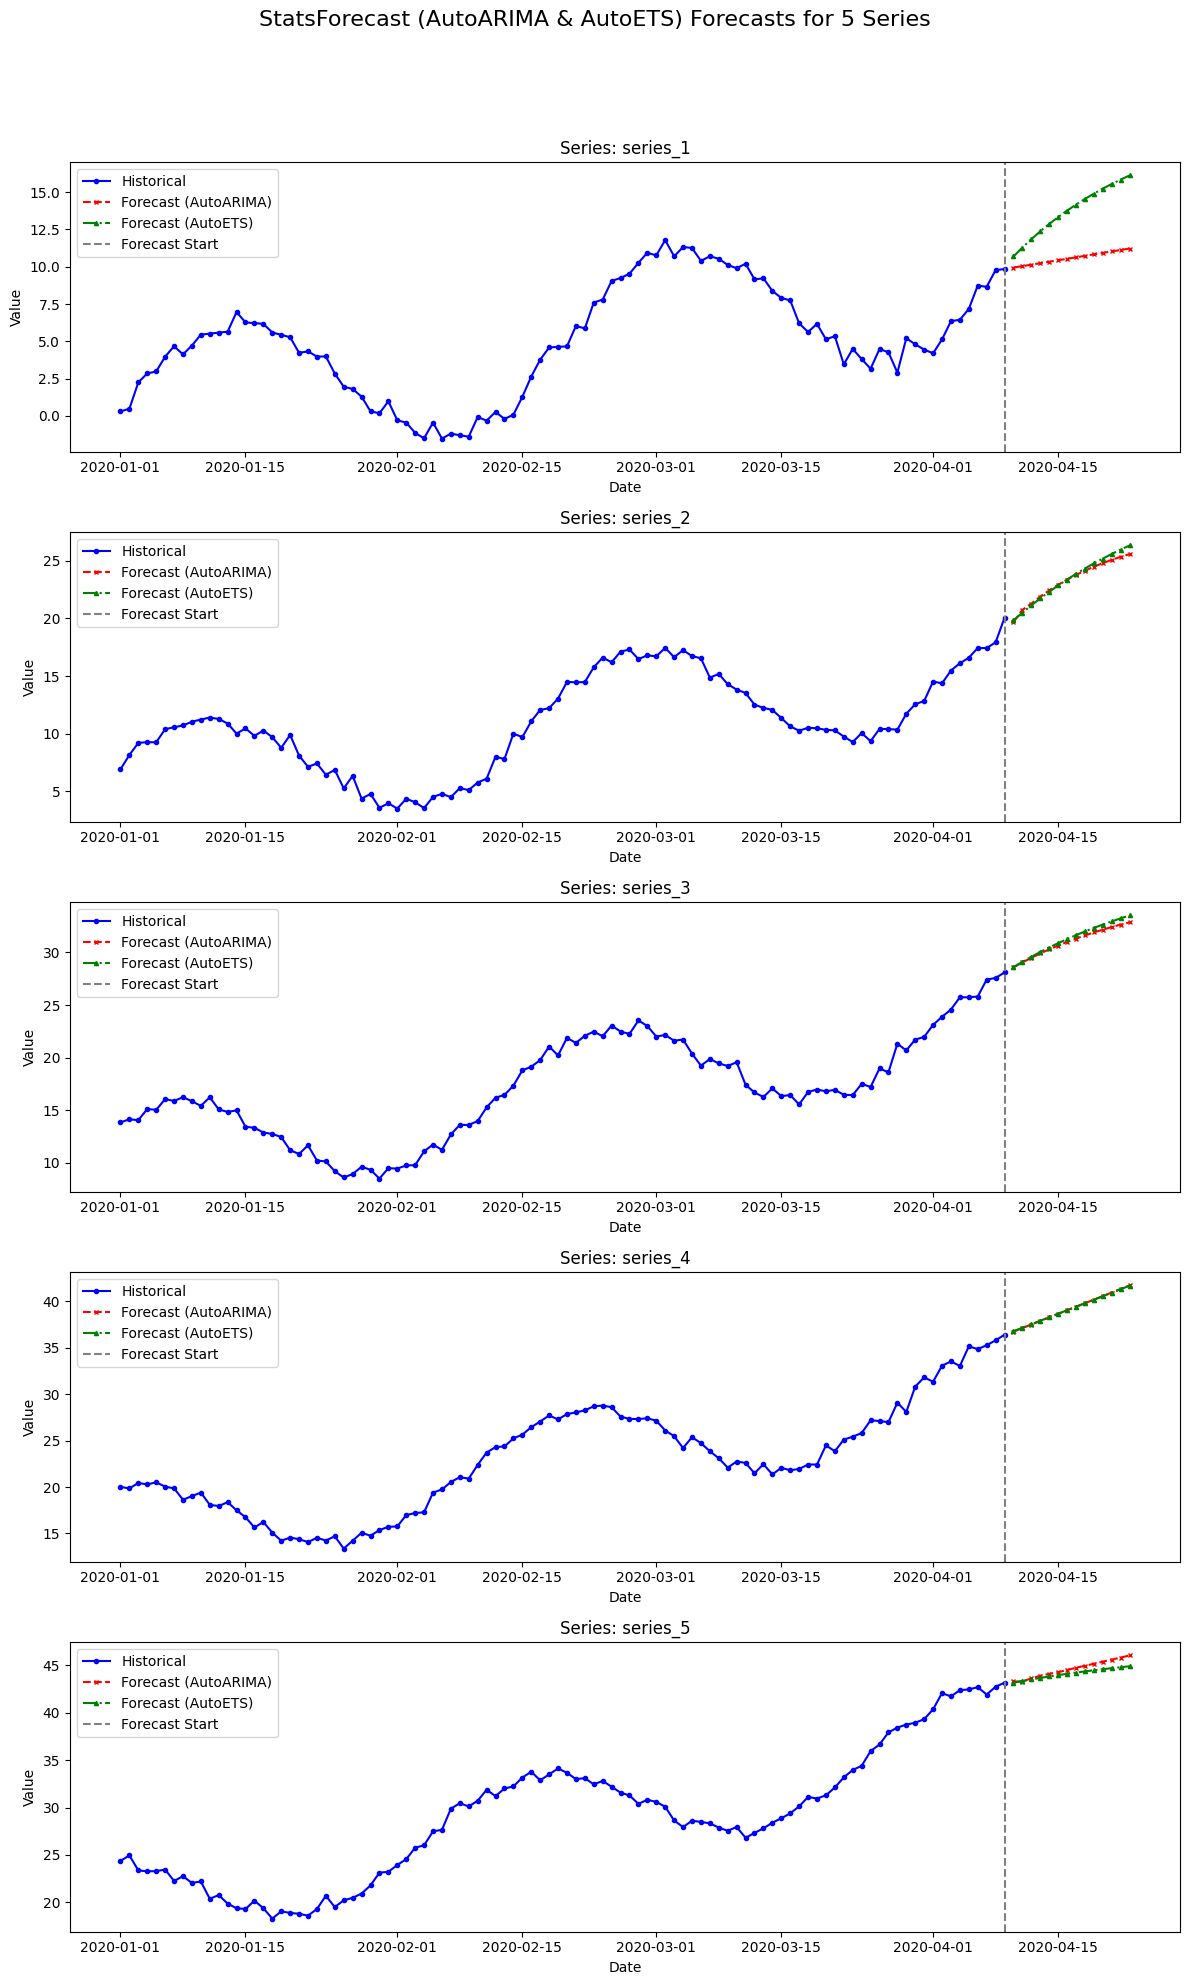


Demonstration complete. Check the plots for forecasts.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS # Corrected import for AutoETS

# print(f"Nixtla StatsForecast version: {StatsForecast.__version__}") # Removed this line

# --- 1. Generate Synthetic Time Series Data ---
# Let's create a dataset with multiple time series (common in real-world scenarios)
# Each series will have a unique_id, a datetime (ds), and a value (y)

num_series = 5
series_length = 100 # Number of data points per series
start_date = pd.to_datetime('2020-01-01')

data = []
for i in range(num_series):
    unique_id = f'series_{i+1}'
    dates = pd.date_range(start=start_date, periods=series_length, freq='D')

    # Generate a base trend, seasonality, and some noise
    trend = np.linspace(0, 10 + i * 2, series_length) # Different trends for each series
    # Using a slightly different seasonality function for variety
    seasonality = 5 * np.sin(np.linspace(0, 4 * np.pi, series_length) + i * 0.5)
    noise = np.random.normal(0, 0.5, series_length)

    y = trend + seasonality + noise + i * 5 # Offset for each series

    series_df = pd.DataFrame({
        'unique_id': unique_id,
        'ds': dates,
        'y': y
    })
    data.append(series_df)

df = pd.concat(data).reset_index(drop=True)

print("\nSample of the generated data:")
print(df.head())
print(f"\nTotal data points: {len(df)}")
print(f"Number of unique series: {df['unique_id'].nunique()}")

# --- 2. Define the Forecasting Horizon ---
# How many steps into the future do we want to predict?
horizon = 14 # Predict next 14 days

# --- 3. Initialize and Fit the StatsForecast Model ---
# StatsForecast expects a list of models
# We'll use AutoARIMA and AutoETS, which automatically find the best parameters
models = [AutoARIMA(), AutoETS()]

sf = StatsForecast(
    models=models,
    freq='D', # Frequency of your time series data (e.g., 'D' for daily)
    n_jobs=-1, # Use all available CPU cores for parallel processing
    verbose=True # Print progress
)

print("\nFitting the model...")
# The fit method takes the dataframe with 'unique_id', 'ds', 'y' columns
# It will fit a separate model for each unique_id
sf.fit(df)
print("Model fitting complete.")

# --- 4. Make Predictions ---
print(f"\nMaking predictions for the next {horizon} steps...")
# The predict method returns a dataframe with unique_id, ds, and predicted values
# (and confidence intervals if enabled, which is default for many models)
forecast_df = sf.predict(h=horizon)

print("\nSample of the forecasted data:")
print(forecast_df.head())

# --- 5. Visualize the Forecasts ---
print("\nPlotting forecasts...")
fig, axes = plt.subplots(num_series, 1, figsize=(12, 4 * num_series), sharex=False)
# Adjust subplots to handle single series case correctly
if num_series == 1:
    axes = [axes] # Make it a list so we can iterate

fig.suptitle(f'StatsForecast (AutoARIMA & AutoETS) Forecasts for {num_series} Series', y=1.02, fontsize=16)

# Get the last observed date for each series to draw a separation line
last_observed_dates = df.groupby('unique_id')['ds'].max().reset_index()

for i, unique_id in enumerate(df['unique_id'].unique()):
    ax = axes[i]

    # Plot historical data
    historical_data = df[df['unique_id'] == unique_id]
    ax.plot(historical_data['ds'], historical_data['y'], label='Historical', color='blue', marker='o', markersize=3, linestyle='-')

    # Plot AutoARIMA forecast
    series_forecast = forecast_df[forecast_df['unique_id'] == unique_id]
    ax.plot(series_forecast['ds'], series_forecast['AutoARIMA'], label='Forecast (AutoARIMA)', color='red', marker='x', markersize=3, linestyle='--')

    # Check if confidence intervals exist for AutoARIMA and plot them
    if 'AutoARIMA-lo-95' in series_forecast.columns and 'AutoARIMA-hi-95' in series_forecast.columns:
        ax.fill_between(series_forecast['ds'], series_forecast['AutoARIMA-lo-95'], series_forecast['AutoARIMA-hi-95'],
                        color='red', alpha=0.2, label='AutoARIMA 95% CI')

    # Plot AutoETS forecast
    ax.plot(series_forecast['ds'], series_forecast['AutoETS'], label='Forecast (AutoETS)', color='green', marker='^', markersize=3, linestyle='-.')

    # Check if confidence intervals exist for AutoETS and plot them
    if 'AutoETS-lo-95' in series_forecast.columns and 'AutoETS-hi-95' in series_forecast.columns:
        ax.fill_between(series_forecast['ds'], series_forecast['AutoETS-lo-95'], series_forecast['AutoETS-hi-95'],
                        color='green', alpha=0.1, label='AutoETS 95% CI')


    # Add a vertical line at the forecast start
    last_date = last_observed_dates[last_observed_dates['unique_id'] == unique_id]['ds'].iloc[0]
    ax.axvline(x=last_date, color='gray', linestyle='--', label='Forecast Start')

    ax.set_title(f'Series: {unique_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.0) # Reduce grid alpha for cleaner look

plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
plt.show()

print("\nDemonstration complete. Check the plots for forecasts.")